# 3-PINN pero añado la identificacion de los parámetros  

## Identificación SOLO de E

In [2]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import re 
import json 
import time
import plotly.express as px


In [3]:
#definicion de parámetros etc  

#parámetros del material
#E = 0.032
#nu = 0.4

#relacion lineal entre tension y deformación
# C=(E/((1+nu)*(1-2*nu)))*torch.tensor(
#     [[1-nu,nu,nu,0,0,0],
#      [nu,1-nu,nu,0,0,0],
#      [nu,nu,1-nu,0,0,0],
#      [0,0,0,(1-2*nu)/2,0,0],
#      [0,0,0,0,(1-2*nu)/2,0],
#      [0,0,0,0,0,(1-2*nu)/2]]).cuda()

#G = E/(2*(1+nu))


seed_id = 1234

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print(torch.cuda.get_device_name(device))

# Set default dtype to float32
torch.set_default_dtype(torch.float32)
# PyTorch random number generator
torch.manual_seed(seed_id)
# Random number generators in other libraries
np.random.seed(seed_id)

Using device: cuda
NVIDIA A2


# Funciones para la carga y le tratado de los datos


In [4]:
def normalize(X_tensor, X_min, X_max):
    """
    Normalize a tensor by columns given a max and min of each column.
    
    Parameters:
    X_tensor(numpy array): Tensor to be normalized.
    """
    # Normalize input vector X by each feature
    (num_row_X, num_col_X) = X_tensor.shape
    normalized_X_tensor = torch.zeros_like(X_tensor)
    
    # Fill the copy vector
    for col in range(num_col_X):
        min_X_col = X_min[col]
        max_X_col = X_max[col]
        normalized_X_tensor[:,col] = (X_tensor[:,col]-min_X_col)/(max_X_col-min_X_col)#(X_tensor[:,col]-min_X_col)*2/(max_X_col-min_X_col)# -1 #para que es este -1?  
        
    return normalized_X_tensor

def unnormalize(X_tensor, X_min, X_max):
    """
    Unnormalize a tensor by columns given a max and min of each column.
    
    Parameters:
    X_tensor(numpy array): Tensor to be unnormalized.
    X_max(numpy array): Max of each column of the tensor to be unnormalized.
    X_min(numpy array): Min of each column of the tensor to be unnormalized.
    """
    # Unnormalize input vector X by each feature
    (num_row_X, num_col_X) = X_tensor.shape
    unnormalized_X_tensor = torch.zeros_like(X_tensor)
    
    # Fill the copy vector
    for col in range(num_col_X):
        unnormalized_X_tensor[:,col] = (X_tensor[:,col])*(X_max[col]-X_min[col]) + X_min[col]#(X_tensor[:,col]+1)*(X_max[col]-X_min[col])/2 + X_min[col]
        
    return unnormalized_X_tensor

In [5]:
def keep_line(line):
    line_split=line.split()
    try:
        int(line_split[0])
        #si no dio error, okey entra
        return True
    except:
        return False

In [6]:
#vamos a hacer una función para cargar todos los datos de una   
def load_data(folder,E,load_stage=10):
    # carga las posiciones de los nodos    
    ititialPosition_data_path = "./data/ARTURO_TEST_1/NODES.txt"

    with open(ititialPosition_data_path,"r") as f:
        aux_list=f.readlines()

    ititialPosition_data=[i for i in aux_list if keep_line(i)]
    ititialPosition_data=[i.strip("\n") for i in ititialPosition_data]
    ititialPosition_data=[i.split() for i in ititialPosition_data]
    ititialPosition_data_np=np.array(ititialPosition_data).astype(float)[:,[0,1,2,3]]
    ititialPosition_data_pd=pd.DataFrame(ititialPosition_data_np,columns=["Node","X","Y","Z"]).set_index("Node")

    #carga el streess
    stress_data_path = f"./data/{folder}/PSOL_{load_stage}_NODAL_STRESSES_E{E}.txt"

    with open(stress_data_path,"r") as f:
        aux_list=f.readlines()


    stress_data=[i for i in aux_list if keep_line(i)]
    stress_data=[i.strip("\n").strip() for i in stress_data]
    patron = "[-.\d]+E-*\d{3}|^\d{0,4}|0\.0000"

    stress_data=[re.findall(patron,i) for i in stress_data]
    stress_data=np.array(stress_data,dtype=float)
    stress_data=pd.DataFrame(stress_data,columns=["Node","SX","SY","SZ","SXY","SYZ","SXZ"]).set_index("Node")

    # cargar datos de desplazamiento  
    displacement_data_path = f"./data/{folder}/PSOL_{load_stage}_NODAL_DISP_E{E}.txt"

    with open(displacement_data_path,"r") as f:
        aux_list=f.readlines()


    displacement_data=[i for i in aux_list if keep_line(i)]
    displacement_data=[i.strip("\n").strip() for i in displacement_data]
    patron = r"[-.\d]+E-*\d{3}|^\d{0,4}|-?\d+\.\d+|0\.0000"

    displacement_data=[re.findall(patron,i) for i in displacement_data]
    displacement_data=np.array(displacement_data,dtype=float)
    displacement_data=pd.DataFrame(displacement_data,columns=["Node","UX","UY","UZ","USUM"]).set_index("Node")

    # cargar datos de boundaries en el movimiento
    #cargar los nodos fijos
    with open("./data/ARTURO_TEST_1/RESTRINGED_NODES.txt","r") as f:
        restricted_data=f.readlines()

    restricted_data=[i for i in restricted_data if keep_line(i)]
    restricted_data=[i.strip("\n") for i in restricted_data]
    restricted_data=[i.split() for i in restricted_data]
    restricted_data_np=np.array(restricted_data)[:,[0,1]]
    restricted_data_pd=pd.DataFrame(restricted_data_np,columns=["Node","Direccion"])
    restricted_data_pd=restricted_data_pd.groupby("Node")["Direccion"].apply(lambda x : list(x)).to_frame().sort_index()
    restricted_data_pd.index=restricted_data_pd.index.astype(int)
    restricted_data_pd=restricted_data_pd.sort_index()
    restricted_data_pd=restricted_data_pd.rename(columns={"Direccion":"Restricciones"})

    with open("./data/ARTURO_TEST_1/FORCE_ON_NODES.txt","r") as f:
        force_data=f.readlines()


    force_data=[i for i in force_data if keep_line(i)]
    force_data=[i.strip("\n") for i in force_data]
    force_data=[i.split() for i in force_data]
    force_data_np=np.array(force_data)[:,[0,1,2]]
    force_data_pd=pd.DataFrame(force_data_np,columns=["Node","Direccion_Fuerza","Fuerza"])
    force_data_pd["Fuerza"]=force_data_pd["Fuerza"].astype(float)
    force_data_pd=force_data_pd.set_index("Node")
    force_data_pd.index=force_data_pd.index.astype(int)


    #ponemos todos los datos en común usando los nodos como clave   
    final_data=ititialPosition_data_pd.merge(stress_data,left_index=True,right_index=True,how="left").merge(force_data_pd,left_index=True,right_index=True,how="left").merge(displacement_data,left_index=True,right_index=True,how="left").merge(restricted_data_pd,left_index=True,right_index=True,how="left")

    final_data["Final_X"]=final_data["X"]-final_data["UX"]
    final_data["Final_Y"]=final_data["Y"]-final_data["UY"]
    final_data["Final_Z"]=final_data["Z"]-final_data["UZ"]


    return final_data

In [7]:
def get_colloc_points(final_df,n_points=None,type="random_1"):
    min_X=final_df["X"].min()
    max_X=final_df["X"].max()

    min_Y=final_df["Y"].min()
    max_Y=final_df["Y"].max()

    min_Z=final_df["Z"].min()
    max_Z=final_df["Z"].max()

    global Pos_min
    global Pos_max

    Pos_min = torch.tensor([min_X, min_Y, min_Z])
    Pos_max = torch.tensor([max_X, max_Y, max_Z])

    if type=="random_1":

        X_coloc = np.random.uniform(min_X, max_X, (n_points, 1))
        Y_coloc = np.random.uniform(min_Y, max_Y, (n_points, 1))
        Z_coloc = np.random.uniform(min_Z, max_Z, (n_points, 1))
        col_points = np.array(np.meshgrid(X_coloc, Y_coloc,Z_coloc)).T.reshape(-1, 3)           # Combine the two arrays
        
        #train_coloc = torch.tensor(comb_array,requires_grad=True).to(device)   
        return col_points
    
    elif type=="random_2":
        #este tipo de random es una distribucion por todo el espacio para cada punto
        points=[]
        for _ in range(n_points):
            X_coloc_aux = np.random.uniform(min_X, max_X, 1)
            Y_coloc_aux = np.random.uniform(min_Y, max_Y, 1)
            Z_coloc_aux = np.random.uniform(min_Z, max_Z, 1)
            points.append(np.array([X_coloc_aux,Y_coloc_aux,Z_coloc_aux]))

        return np.array(points).reshape(-1, 3)

## Modelo   


In [8]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        self.layers=layers
        'activation function'
        self.activation = nn.Tanh()
    
        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    

        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)             

        xn = normalize(x, Pos_min, Pos_max)         # Normalize the input

        # #convert to float
        a = xn.float()

        # inpunt and hidden layers forward computation
        for i in range(len(self.layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)

        # output layer forward computation            
        a = self.linears[-1](a)
        
        return a

In [11]:
class PINN(DNN):
    def __init__(self, layers,init_values=None):
        super().__init__(layers)
        self.to(device)    
        
        'Define loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'History of losses'
        self.loss_history = {"Data": [],
                             "PDE": [],
                             "BC": [],
                             "Total":[]}
        'Parameters trials'
        self.params_history = { "nu": [],
                                "E": [] ,
                                "alpha": []}
        self.init_values=init_values
        self.nu=self.init_values[0]#nn.Parameter(torch.tensor(init_values[0],dtype=torch.float32).to(device))#torch.tensor(init_values[0],dtype=torch.float32).to(device)#
        self.alpha=nn.Parameter(torch.tensor(0.1,dtype=torch.float32).to(device))
        self.E=torch.tensor((1+self.alpha)*self.init_values[1],dtype=torch.float32).to(device)
    

        # self.register_parameter('nu', self.nu)  
        # self.register_parameter('E', self.E)
    def loss_data(self, x, u_real, save = False):
        #aqui están las restricciones de movimiento tanto de xyz como las de y solo
        #estamo suponiendo que eso es suficiente para que la red lo aprenda
        #le estamos metiendo todos los nodos que están quietos, y también le vamos a meter
        #todos los que solo se pueden desplazar en dos direcciones, 

        #esta pendiente, en estos con una restriccion en una sola dirección, calcular la loss
        #SOLO en esa direccion 

        
        u_nn = self(x)
     
        loss_d = self.loss_function(u_nn, u_real)
        
        save and self.loss_history["Data"].append(loss_d.to('cpu').detach().numpy()) 
        
        return loss_d
        
    def loss_PDE(self, pos_f, save = False):

        nu=self.nu 
                       
        # clone the input data and add AD
       
        pos = pos_f.clone().to(torch.float32)

        # predict u
        U = self(pos)

        #primeras derivadas 

        dU = autograd.grad(U, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        U_shifted1 = torch.roll(U, 1, 1)
        dU_1 = autograd.grad(U_shifted1, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]
        U_shifted2 = torch.roll(U, 1, 1)
        dU_2 = autograd.grad(U_shifted2, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        # second derivatives

        ddU = autograd.grad(dU, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        u_xx = ddU[:,0].reshape(-1,1)
        v_yy = ddU[:,1].reshape(-1,1)
        w_zz = ddU[:,2].reshape(-1,1)

        ddU_1 = autograd.grad(dU_1, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        w_xx = ddU_1[:,0].reshape(-1,1)
        u_yy = ddU_1[:,1].reshape(-1,1)
        v_zz = ddU_1[:,2].reshape(-1,1)

        ddU_2 = autograd.grad(dU_2, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        v_xx = ddU_2[:,0].reshape(-1,1)
        w_yy = ddU_2[:,1].reshape(-1,1)
        u_zz = ddU_2[:,2].reshape(-1,1)


        # Shift columns of du tensor
        dU_shifted = torch.roll(dU, 1, 1)

        cross_ddU_1 = autograd.grad(dU_shifted, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        w_xz = cross_ddU_1[:,0].reshape(-1,1)
        u_yx = cross_ddU_1[:,1].reshape(-1,1)
        v_zy = cross_ddU_1[:,2].reshape(-1,1)

        cross_ddU_2 = autograd.grad(dU_shifted, pos, torch.ones([pos.shape[0], 3]).cuda().to(device),retain_graph=True, create_graph=True)[0]

        v_xy = cross_ddU_2[:,0].reshape(-1,1)
        w_yz = cross_ddU_2[:,1].reshape(-1,1)
        u_zx = cross_ddU_2[:,2].reshape(-1,1)

        f = [(u_xx+u_yy+u_zz) + (1)/(1-2*nu)*(u_xx + v_xy + w_xz),
             (v_xx+v_yy+v_zz) + (1)/(1-2*nu)*(u_yx + v_yy + w_yz),
             (w_xx+w_yy+w_zz) + (1)/(1-2*nu)*(u_zx + v_zy + w_zz) ] #aqui no influye E porque estamos igualando esto a 0 , y E es comun a todo.

        f_tensor= torch.cat((f[0], f[1], f[2]), dim=1).to(torch.float32).to(device)
        
        # f_hat is just an auxiliar term to copmute the loss (is zero)
        loss_f = self.loss_function(f_tensor, torch.zeros_like(f_tensor).to(torch.float32).to(device) ) 

        save and self.loss_history["PDE"].append(loss_f.to('cpu').detach().numpy()) 
        return loss_f


    def loss_BC(self, pos_bc,sigma_bc, save = False):
        #nuestras condiciones serán hacer que en los nodos donde se aplica la fuerza, las tensiones 
        #sean las registradas para la dirección en la que se aplican, -Y
        
        # clone the input data and add AD
        #pos = pos_bc.clone().to(torch.float32)
        
        # predict U
        X,Y,Z=self.compute_XYZ(pos_bc)
        U,V,W=self.compute_displacements(X,Y,Z)
        
        #tenemos que calcular la epsilon, tenemos que sacarla asi: \epsilon=1/2(\nabla u + (\nabla u )^T)
        nabla_U = self.compute_gradU(U,V,W,X,Y,Z).squeeze()
        strain = 0.5 * (nabla_U + nabla_U.swapaxes(1,2))


        #ahora calculamos el tensor de stres que en este caso es lineal conociendo C
        sigma=self.compute_stress(strain)

        loss_bc = self.loss_function(sigma.to(torch.float32), sigma_bc.to(torch.float32)) 
        
        save and self.loss_history["BC"].append(loss_bc.to('cpu').detach().numpy()) 

        return loss_bc
    # Al hacerlo todo desde los desplazamientos, esto no tiene sentido, porque la sigma - *epsilon=0 ya se está cumpliendo por definicion de como calculamos las cosas
    # def loss_constitutive(self,pos_f,save):
    #     #esta los impondra que se cumpla la ecuacion constitutiva de elasticidad lineal  
    #     # predict U
    #     X,Y,Z=self.compute_XYZ(pos_f)
    #     U,V,W=self.compute_displacements(X,Y,Z)
        
    #     #tenemos que calcular la epsilon, tenemos que sacarla asi: \epsilon=1/2(\nabla u + (\nabla u )^T)
    #     nabla_U = self.compute_gradU(U,V,W,X,Y,Z).squeeze()
    #     strain = 0.5 * (nabla_U + nabla_U.swapaxes(1,2))


    #     #ahora calculamos el tensor de stres que en este caso es lineal conociendo C
    #     sigma=self.compute_stress(strain)
    #     const_res=sigma - 
    #     loss_cons = self.loss_function(const_res, torch.zeros_like(const_res).to(torch.float32).to(device) )



    def loss(self, pos_real, despl_real, pos_f, pos_bc,sigma_bc, save = False):
        self.E=(1+self.alpha)*self.init_values[1]
        loss_d  = self.loss_data(pos_real, despl_real, save)
        loss_f  = self.loss_PDE( pos_f, save) 
        loss_bc = self.loss_BC(pos_bc,sigma_bc, save)
        
        loss_val =loss_d  + loss_f  +loss_bc
        #loss_val = (1/(epsilon+loss_d))*loss_d  + (1/(epsilon+loss_f))*loss_f + (1/(epsilon+loss_bc))*loss_bc
        if save: 
            self.params_history["nu"].append(self.nu)#self.nu.to('cpu').detach().numpy())
            self.params_history["E"].append(self.E.to('cpu').detach().numpy())
            self.params_history["alpha"].append(self.alpha.to('cpu').detach().numpy())
            self.loss_history["Total"].append(loss_val.to('cpu').detach().numpy())
        return loss_val

    def compute_gradU( self, u, v, w, X, Y, Z, eye=torch.eye(3)):
        # Compute the gradient of U
        Ux = autograd.grad(u, X, torch.ones([X.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Uy = autograd.grad(u, Y, torch.ones([Y.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Uz = autograd.grad(u, Z, torch.ones([Z.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]

        # Compute the gradient of V
        Vx = autograd.grad(v, X, torch.ones([X.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Vy = autograd.grad(v, Y, torch.ones([Y.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Vz = autograd.grad(v, Z, torch.ones([Z.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        
        # Compute the gradient of W
        Wx = autograd.grad(w, X, torch.ones([X.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Wy = autograd.grad(w, Y, torch.ones([Y.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        Wz = autograd.grad(w, Z, torch.ones([Z.shape[0], 1]).cuda(),retain_graph=True, create_graph=True)[0]
        
        grad_u = torch.cat((Ux , Uy, Uz), dim=1).to(torch.float32)
        grad_v = torch.cat((Vx , Vy, Vz), dim=1).to(torch.float32)
        grad_w = torch.cat((Wx , Wy, Wz), dim=1).to(torch.float32)

        gradU = torch.cat((grad_u, grad_v, grad_w), dim=1).to(torch.float32).reshape(-1,3,3)

        return gradU

    def compute_stress(self,strain):
        strain_flat=strain[:,(0,1,2,1,0,0),(0,1,2,2,2,1)]*torch.tensor([1,1,1,2,2,2],dtype=torch.float32).to(device)

        C=(self.E/((1+self.nu)*(1-2*self.nu)))*torch.tensor(
                [[1-self.nu,self.nu,self.nu,0,0,0],
                [self.nu,1-self.nu,self.nu,0,0,0],
                [self.nu,self.nu,1-self.nu,0,0,0],
                [0,0,0,(1-2*self.nu)/2,0,0],
                [0,0,0,0,(1-2*self.nu)/2,0],
                [0,0,0,0,0,(1-2*self.nu)/2]]).to(device)
        
        return torch.matmul(C,strain_flat.T.float()).T.squeeze()
    
    def compute_XYZ(self, positions):
        # clone the input data and add AD
        pos = positions.clone()
        X = pos[:,0].reshape(-1,1)
        Y = pos[:,1].reshape(-1,1)
        Z = pos[:,2].reshape(-1,1)
        return X, Y, Z

    def compute_displacements(self,X, Y, Z):
        XYZ = torch.cat((X,Y,Z), dim=1)

        # Compute the output of the DNN
        U = self(XYZ)               

        # Separating vector of directional displacements
        u = U[:,0].reshape(-1,1)
        v = U[:,1].reshape(-1,1)
        w = U[:,2].reshape(-1,1)

        return u, v, w

In [12]:
'Neural Network Summary'
layers=[3,20,20,40,40,20,3]
epochs=500

nu_real = 0.4
nu_init=nu_real#0.1 
E_options=["0.020"]#,"0.040","0.050","0.060"]#["0.005","0.009"]
E_inits=[0.01]
times={}
logs_E={}
for i,E_real_str in enumerate(E_options):
    print("========\n","E_real:", E_real_str,"\n========")
    # parte de carga de los datos para un E concreto  
    E_real_num=float(E_real_str)

    final_df=load_data("MULTIPLE_E_VALUES",E_real_str,10)
    if i==0:
        coloc_points=get_colloc_points(final_df,120000,"random_2")
        train_coloc = torch.tensor(coloc_points,requires_grad=True).to(device)
    #extraemos del final_df los datos necesarios   
    nodos_with_force_data=final_df.loc[final_df.apply(lambda x : (not np.isnan(x.Fuerza)) & (not np.isnan(x.SY)),axis=1),["X","Y","Z","SX","SY","SZ","SXY","SYZ","SXZ","Restricciones"]]
    nodos_with_force_data=nodos_with_force_data.loc[nodos_with_force_data["Restricciones"].isna()].drop(columns=["Restricciones"])

    not_limited_nodes_data=final_df.loc[final_df.apply(lambda x : np.isnan(x["Restricciones"]) if not isinstance(x["Restricciones"], list) else False ,axis=1),["X","Y","Z","UX","UY","UZ"]]

    notlimited_traindata=not_limited_nodes_data.sample(frac=0.8,axis=0)
    notlimited_testdata=not_limited_nodes_data.loc[[i not in notlimited_traindata.index for i in not_limited_nodes_data.index]]

    data_BC_fix3=final_df.loc[final_df.apply(lambda x : len(x["Restricciones"])==3 if isinstance(x["Restricciones"], list) else False ,axis=1),["X","Y","Z","UX","UY","UZ"]]
    data_BC_fix1_Y=final_df.loc[final_df.apply(lambda x : len(x["Restricciones"])==1 if isinstance(x["Restricciones"], list) else False ,axis=1),["X","Y","Z","UX","UY","UZ"]]

    train_data=pd.concat([notlimited_traindata,data_BC_fix3,data_BC_fix1_Y])
    train_data=train_data.sample(frac=1) #esto está para shuflear






    xyz_train=torch.tensor(train_data[["X","Y","Z"]].values,requires_grad=True).to(torch.float32).to(device)
    uvw_train=torch.tensor(train_data[["UX","UY","UZ"]].values,requires_grad=True).to(torch.float32).to(device)

    xyz_bc_train=torch.tensor(nodos_with_force_data[["X","Y","Z"]].values,requires_grad=True).to(torch.float32).to(device)

    sigma_bc_train=torch.tensor(nodos_with_force_data[["SX","SY","SZ","SXY","SXZ","SYZ"]].to_numpy(),requires_grad=True).to(torch.float32).to(device)


    xyz_test=torch.tensor(notlimited_testdata[["X","Y","Z"]].values,requires_grad=True).to(torch.float32).to(device)
    uvw_test=torch.tensor(notlimited_testdata[["UX","UY","UZ"]].values,requires_grad=True).to(torch.float32).to(device)

    notlimited_testdata["desp"]=np.sqrt(notlimited_testdata["UX"]**2+notlimited_testdata["UY"]**2+notlimited_testdata["UZ"]**2)





    'Neural Network Parameters'
    #params = list(pinn.parameters())



    #vamos a hacer un bucle para diferentes valores iniciales de E

    dict_E_inits={}
    for E_init in E_inits:
        time_init=time.time()
        pinn = PINN(layers,[nu_init,E_init])
        lr_init=1e-2

        optimizer = torch.optim.Adam(pinn.parameters(), lr=lr_init)

        print("E_init:",E_init)
        for i,epoch in enumerate(range(epochs)):
            if epoch==100:
                optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
            if epoch==1500:
                optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)

            

            # Make predictions for this batch
            outputs_xyz = pinn(xyz_train)
            optimizer.zero_grad()
            # Compute the loss and its gradients
            loss = pinn.loss(xyz_train, uvw_train, train_coloc, xyz_bc_train,sigma_bc_train, save = True)
            print("\t Epoch: ",epoch, "Loss: ", loss.cpu().detach().numpy(),"E: ", pinn.E.detach().cpu().numpy().squeeze(),"alpha: ", pinn.alpha.detach().cpu().numpy().squeeze())
            loss.backward()

            # Adjust learning weights
            optimizer.step()
        time_fin=time.time()
        times[f"{E_real_str}_{E_init}"]=time_fin-time_init
        dict_E_inits[str(E_init)]={"E_value":np.array(pinn.params_history["E"]).tolist(),"losses":{k:np.array(v).tolist() for k,v in pinn.loss_history.items()}}
            
    logs_E[E_real_str]=dict_E_inits



 E_real: 0.020 


/tmp/ipykernel_92050/4010480431.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  notlimited_testdata["desp"]=np.sqrt(notlimited_testdata["UX"]**2+notlimited_testdata["UY"]**2+notlimited_testdata["UZ"]**2)
/tmp/ipykernel_92050/3065837871.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.E=torch.tensor((1+self.alpha)*self.init_values[1],dtype=torch.float32).to(device)


E_init: 0.01
	 Epoch:  0 Loss:  1.4742243 E:  0.011 alpha:  0.1
	 Epoch:  1 Loss:  0.6742889 E:  0.011097573 alpha:  0.10975733
	 Epoch:  2 Loss:  0.59794515 E:  0.0111535955 alpha:  0.11535949
	 Epoch:  3 Loss:  0.5290768 E:  0.011194021 alpha:  0.11940211
	 Epoch:  4 Loss:  0.4621614 E:  0.011228806 alpha:  0.12288068
	 Epoch:  5 Loss:  0.42171714 E:  0.011258364 alpha:  0.12583642
	 Epoch:  6 Loss:  0.4224526 E:  0.011294463 alpha:  0.12944625
	 Epoch:  7 Loss:  0.41688433 E:  0.01134041 alpha:  0.13404104
	 Epoch:  8 Loss:  0.4217043 E:  0.01138005 alpha:  0.13800506
	 Epoch:  9 Loss:  0.41690856 E:  0.011385509 alpha:  0.1385509
	 Epoch:  10 Loss:  0.4049463 E:  0.0113560455 alpha:  0.1356046
	 Epoch:  11 Loss:  0.39248508 E:  0.011304631 alpha:  0.13046308
	 Epoch:  12 Loss:  0.37282383 E:  0.011239206 alpha:  0.12392068
	 Epoch:  13 Loss:  0.36848253 E:  0.011163875 alpha:  0.11638758
	 Epoch:  14 Loss:  0.37180707 E:  0.0110813035 alpha:  0.108130336
	 Epoch:  15 Loss:  0.35712

In [10]:
results_dir="/home/arturosf/Documentos/repos/ElasticityPINN/examples/LinearProstata/results/3.1.2.5_medirTimes"
with open(f"{results_dir}/2000_logs.json","w") as f:
    json.dump(logs_E,f)

with open(f"{results_dir}/times.json","w") as f:
    json.dump(times,f)


In [12]:
plt.style.use('default')

for E_str in E_options:
    E_real=float(E_str)
    aux_dict_E_inits=logs_E[E_str]
    fig,ax=plt.subplots()
    x1, x2, y1, y2 = -1, 400, E_real-0.05, E_real+0.05  # subregion of the original image
    axins = ax.inset_axes([0.3, 0.6, 0.67, 0.4],xlim=(x1, x2), ylim=(y1, y2))
    for i in E_inits:
        ax.plot(aux_dict_E_inits[str(i)]["E_value"],alpha=0.79,label=f"Init E value: {i}")
        ax.axhline(E_real,linestyle="-.",alpha=0.8,color="red",linewidth=0.3)
        ax.set_ylabel("E_init")
        ax.set_xlabel("Epochs")
        axins.plot(aux_dict_E_inits[str(i)]["E_value"])
        axins.axhline(E_real,linestyle="-.",alpha=0.7,color="red",linewidth=1)

    plt.title(f"E_true: {E_str}")
    ax.indicate_inset_zoom(axins, edgecolor="black")
    plt.tight_layout()
    plt.savefig(f"/home/arturosf/Documentos/repos/ElasticityPINN/examples/LinearProstata/results/3.1.2.5_medirTimes/{E_str}.png")
    plt.close()


/tmp/ipykernel_78644/2405465446.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


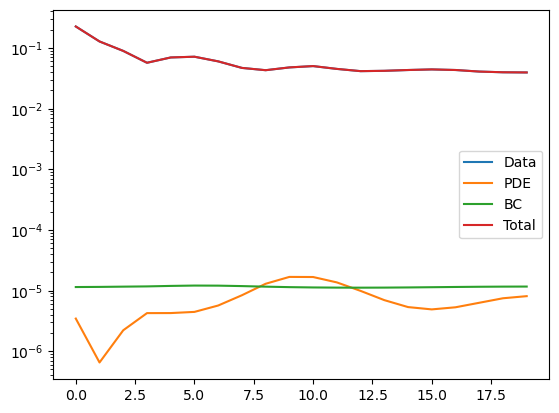

In [13]:
plt.plot(pinn.loss_history["Data"], label='Data')
plt.plot(pinn.loss_history["PDE"], label='PDE')
plt.plot(pinn.loss_history["BC"], label='BC')
plt.plot(pinn.loss_history["Total"], label='Total')
plt.yscale('log')
plt.legend()
plt.show()
#plt.savefig('PINN_LEP_Losses.png')

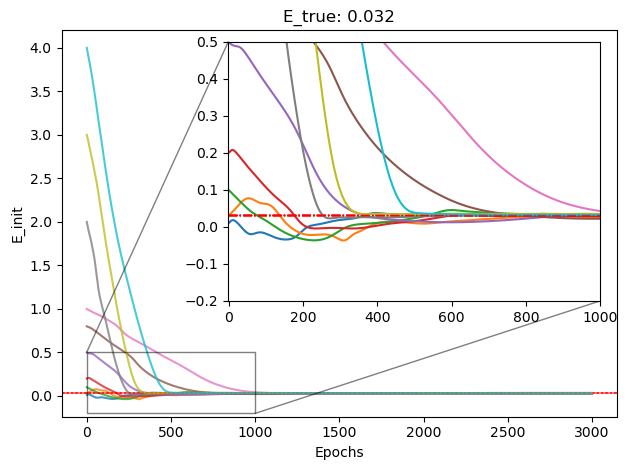

In [ ]:
plt.style.use('default')


fig,ax=plt.subplots()
x1, x2, y1, y2 = -1, 1000, -0.2, 0.5  # subregion of the original image
axins = ax.inset_axes(
[0.3, 0.3, 0.67, 0.67],
xlim=(x1, x2), ylim=(y1, y2), )
for i in E_inits[:-2]:
    ax.plot(dict_all_E[i],alpha=0.79,label=f"Init E value: {i}")
    ax.axhline(E_real,linestyle="-.",alpha=0.8,color="red",linewidth=0.3)
    ax.set_ylabel("E_init")
    ax.set_xlabel("Epochs")
    axins.plot(dict_all_E[i])
    axins.axhline(E_real,linestyle="-.",alpha=0.7,color="red",linewidth=1)

plt.title("E_true: 0.032")
ax.indicate_inset_zoom(axins, edgecolor="black")
plt.tight_layout()


#plt.legend()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

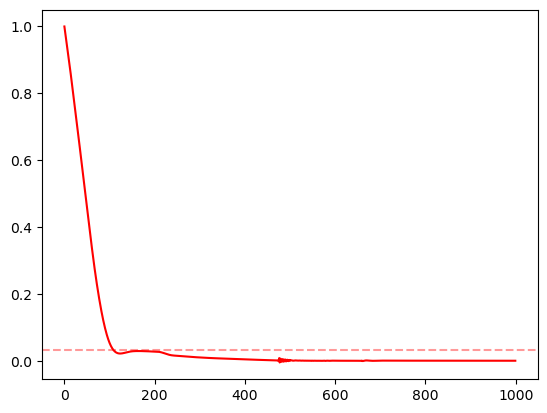

In [19]:
plt.plot(np.arange(epochs),pinn.params_history["E"],color="red",linestyle="-", label='E')
plt.axhline(E_real,color="red",linestyle="--",label='E_real',alpha=0.4)
plt.plot(np.arange(epochs),pinn.params_history["nu"],color="blue",linestyle="-", label='nu')
plt.axhline(nu_real,color="blue",linestyle="--",label='nu_real',alpha=0.4)


#plt.yscale('log')
plt.legend()
plt.show()
